In [1]:
### If save data:
save_data = False

if save_data:
  def ensure_dir(file_path):
    import os
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

  from google.colab import drive
  drive.mount('/content/drive')
  %cd drive/My Drive/
  save_dir = "data/"
  ensure_dir(save_dir)

# Import Libraries and Neural Tangents

In [2]:
import os
import sys
import numpy as npo
import matplotlib.pyplot as plt

import jax.numpy as np
import jax
from jax.config import config
from jax import random
from jax import jit, grad, vmap
from jax.experimental import optimizers

!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax

!pip install -q git+https://github.com/Pehlevan-Group/kernel-generalization
from kernel_generalization import kernel_simulation as ker_sim
from kernel_generalization import kernel_spectrum as ker_spec
from kernel_generalization.utils import gegenbauer

import urllib.request
dir_gegenbauer = os.path.join(os.getcwd(),'GegenbauerEigenvalues.npz')
url = "https://raw.github.com/Pehlevan-Group/kernel-generalization/main/PrecomputedData/GegenbauerEigenvalues.npz"
urllib.request.urlretrieve(url, dir_gegenbauer)

import pytz
from datetime import datetime
from dateutil.relativedelta import relativedelta

def time_now():
  return datetime.now(pytz.timezone('US/Eastern')).strftime("%m-%d_%H-%M")

def time_diff(t_a, t_b):
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

### Using Time difference
### t_start = datetime.now(pytz.timezone('US/Eastern'))
### t_end = datetime.now(pytz.timezone('US/Eastern'))
### print('Time Elapsed: ' + time_diff(t_start,t_end))

print('After running code: ',jax.devices())

After running code:  [GpuDevice(id=0, process_index=0)]


# First Define Your Plot Function

In [3]:
def plot_shift_data(pvals, error, std, Errs_tot, noise_k, noise, exp_type, tr_errs = None):
  i = noise_k
  shift = len(noise[i])
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
  for j in range(shift):
      plt.errorbar(pvals, error[i,j], std[i,j], fmt='o', label = r'$\sigma = %.3f$' % noise[i,j], color=colors[j])
      plt.plot(pvals, Errs_tot[j,:,i], color=colors[j])

  if exp_type == 'kernel':
    plt.title('Interpolating Kernel Regression (Infinite Parameters)')
  else:
    plt.title('Neural Network Training')

  plt.xlabel('samples')
  plt.ylabel('test risk')
  plt.xscale('log')
  plt.yscale('log')
  plt.legend()
  plt.show()

# Functions for Data generating and Neural Networks

In [4]:
# generate sphere vectors
def generate_synth_data(p, dim, key):
  x0 = random.normal(key, shape=(p,dim))
  x = x0 / npo.outer(npo.linalg.norm(x0, axis=1), npo.ones(dim))
  return np.array(x)

## Target function is y(x) = Q_k(beta X)
## It has a single mode and all weights for degenerate modes are the same
def pure_target_fn(X, dim, beta, spectrum, k):
  dim = len(beta)
  lamb = (dim-2)/2
  ## Q(1) from the SI
  Q1 = lamb/(lamb+k)*gegenbauer.degeneracy_kernel(dim, k)

  z = npo.dot(X, beta) 
  d = beta.shape[0]
  y = gegenbauer.gegenbauer(z, dim, d)[k,:]
  # Calculate normalized y:
  y_norm = y*spectrum[k]*((k+lamb)/lamb)

  return np.array(y_norm)

# Generate fully connected NN architecture
def fully_connected(num_layers, width):
  layers = []
  for i in range(num_layers):
    layers += [stax.Dense(width, W_std = 1, b_std = 0), stax.Relu()]
  layers += [stax.Dense(1, W_std = 1, b_std=0)] 
  return stax.serial(*layers)


# Functions for Theory Curves and Experiments


## Theory Curves and NTK Spectrum

In [5]:
def NTK_spectrum(layers, dim, kmax):
  dimension = npo.array([5*(i+1) for i in range(40)])
  degree = npo.array([i for i in range(500)]); 
  layer = npo.array([1, 2, 3, 4, 5, 6, 7, 8, 9]);
  
  dim_index = npo.where(dimension == dim)[0][0]

  lambda_bar, spectrum = ker_spec.ntk_spectrum(dir_gegenbauer, kmax, layer = layers-1, dim = dim_index)
  return lambda_bar, spectrum

def NTK_theory_and_Noise(pvals, layers, dim, kmax, noise_num, shift, R_tilde = 1, fn_mode = 1, zero_mode = False):

  ## Generate spectrum and degeneracies
  k = npo.linspace(0,kmax-1,kmax)
  a = (dim-2)/2 
  kp = ((k+a)/a)

  lambda_bar, spectrum = NTK_spectrum(layers, dim, kmax)
  degens = npo.array([gegenbauer.degeneracy_kernel(dim, k) for k in range(kmax)])

  alpha_s = npo.array([(np.sum(lambda_bar[i+1:]))/lambda_bar[i+1] for i in range(kmax-2)])

  noise = npo.zeros((noise_num, len(shift)))
  for i in range(noise_num):
      for j in range(len(shift)):
          if alpha_s[i] >= 2:
              alpha = (alpha_s[i]-1)*(1+shift[j])
              noise[i,j] = (2*alpha+1)*spectrum[i+1]**2*degens[i+1]
          else:
              alpha = (alpha_s[i]-1)*(1+shift[j])+1
              noise[i,j] = ker_sim.noise(alpha)*spectrum[i+1]**2*degens[i+1]

  Sol = npo.zeros((len(shift), len(pvals), kmax, noise_num))
  Errs_tot = npo.zeros((len(shift), len(pvals), noise_num))
  Cum_gen_errs = npo.zeros((len(shift), len(pvals), kmax, noise_num))

  for i in range(len(shift)):
      Sol[i], Errs_tot[i], Cum_gen_errs[i]= ker_sim.simulate_pure_gen_error(pvals, spectrum, degens,
                                                                       noise[:, i], pure_mode = fn_mode, 
                                                                       zero_mode=zero_mode)
  
  ## Scale the theoretical error with test radius (R_train = 1)
  Errs_tot = Errs_tot * R_tilde**2
  return Sol, Errs_tot, noise, alpha_s, spectrum, degens


## Kernel Regression Functions

In [6]:
### Kernel Regression Experiment Synthetic Data ###
### The function generates a pure mode target function and 
### performs kernel regression on a given kernel_fn with
### randomly sampled training and test data on unit "dim"-sphere.

def kernel_expt(kernel_fn, pvals, p_test, sigma, dim, spectrum, num_repeats, all_keys, R_tilde = 1, fn_mode = 1):

  ## First of all we fix a target function by generating a
  ## projection vector "beta" in "dim" dimensions and specifying
  ## the function's mode index "fn_mode" (fn_mode = 1, linear target)
  beta = generate_synth_data(1, dim, all_keys[0,:])[0,:]

  gen_errs = npo.zeros((len(pvals), num_repeats))
  for i, p in enumerate(pvals):
    for j in range(num_repeats):
      
      # Generate fresh training and test data
      tr_key, test_key, noise_key = random.split(all_keys[j,:], 3)
      # Generate random inputs and label noise
      X = generate_synth_data(p, dim, tr_key)
      ## Change the test radius
      X_test = generate_synth_data(p_test, dim, test_key)*R_tilde
      label_noise = npo.sqrt(sigma)*random.normal(noise_key, shape=(p,1))
      # Calculate corresponding labels given the weights beta and fn_mode
      y = pure_target_fn(X, dim, beta, spectrum, fn_mode).reshape(p,1) + label_noise
      y_test = pure_target_fn(X_test, dim, beta, spectrum, fn_mode).reshape(p_test,1)

      ## Perform regression using NeuralTangents Package
      predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, X, y, diag_reg=1e-15)
      yhat = predict_fn(x_test=X_test, get='ntk', compute_cov=False)

      ## Calculate MSE
      gen_errs[i,j] = npo.mean((y_test-yhat)**2)

    ## Calculate repeat averaged errors and standard deviation
    errs = npo.mean(gen_errs, axis = 1)
    std_errs = npo.std(gen_errs, axis = 1)

  return errs, std_errs

## Neural Network Training Functions


In [7]:
# training NN here

def train_nn(key, init_fn, apply_fn, nn_loss, grad_loss, optimizer, X_test, train_set, num_iter):
  
  (X, y) = train_set
  losses = []
  _,params = init_fn(key, (-1, X.shape[1]))

  opt_init, opt_update, get_params = optimizer
  opt_state = opt_init(params)

  for t in range(num_iter):
    opt_state = opt_update(t, grad_loss(opt_state, *train_set), opt_state)
    loss = nn_loss(get_params(opt_state), *train_set)
    losses.append(loss)

  params = get_params(opt_state)
  yhat_ensemble = apply_fn(params, X_test)
  losses = np.array(losses)
  return opt_state, losses, yhat_ensemble

# experiment for sample wise generalization error 
# for overparameterized model
def nn_expt(init_fn, apply_fn, pvals, p_test, sigma, dim, spectrum, num_repeats, all_keys, lr, num_iter, fn_mode = 1, ensemble_size = 1, verbose = True):

  ## First of all we fix a target function by generating a
  ## projection vector "beta" in "dim" dimensions and specifying
  ## the function's mode index "fn_mode" (fn_mode = 1, linear target)
  beta = generate_synth_data(1, dim, all_keys[0,:])[0,:]

  gen_errs = npo.zeros((len(pvals), num_repeats))
  training_errs = []
  training_errs_std = []

  beginning = datetime.now()

  for i, p in enumerate(pvals):
    t_start = datetime.now()
    train_errs_p = []
    for j in range(num_repeats):
      # Generate fresh training and test data
      tr_key, test_key, noise_key = random.split(all_keys[j,:], 3)
      # Generate random inputs and label noise
      X_train = generate_synth_data(p, dim, tr_key)
      X_test = generate_synth_data(p_test, dim, test_key)
      label_noise = npo.sqrt(sigma)*random.normal(noise_key, shape=(p,1))
      # Calculate corresponding labels given the weights beta and fn_mode
      y_train = pure_target_fn(X_train, dim, beta, spectrum, fn_mode).reshape(p,1) + label_noise
      y_test = pure_target_fn(X_test, dim, beta, spectrum, fn_mode).reshape(p_test,1)
      
      train_set = (X_train, y_train)
      test_set = (X_test, y_test)

      if p > 1000:
        num_iter = 2000

      Ktr = kernel_fn(X_train,None,'ntk')
      
      optimizer = optimizers.adam(lr)
      # lr_max = nt.predict.max_learning_rate(Ktr)/10
      # optimizer = optimizers.sgd(lr_max)
      opt_init, opt_update, get_params = optimizer


      nn_loss = jit(lambda params, X, y: np.mean((apply_fn(params, X) - y)**2))
      grad_loss = jit(lambda state, x, y: grad(nn_loss)(get_params(state), x, y))

      ensemble_key = random.split(all_keys[j,:], ensemble_size)
      output = vmap(train_nn, (0, None, None, None, None, None, None, None, None))(ensemble_key, init_fn, apply_fn, nn_loss, grad_loss, 
                                                                                   optimizer, X_test, train_set, num_iter)
      
      opt_state, train_losses, yhat_ensemble = output
      
      ## Perfom ensamble averaging
      train_errs_p += [np.mean(train_losses, axis=0)]
      yhat = np.mean(yhat_ensemble, axis=0)
      gen_errs[i,j] = np.mean((yhat - y_test)**2)

      sys.stdout.write("\r P = %d, gen error: %0.4f | train error: %0.3e | Repeat: %d/%d" 
                             % (p, gen_errs[i,j], train_errs_p[j][-1], j+1, num_repeats))

    t_end = datetime.now()

    # For each P average Gen Error and Training Error over trials
    err = npo.mean(gen_errs[i], axis = 0)
    std_err = npo.std(gen_errs[i], axis = 0)

    tr_err = npo.mean(np.array(train_errs_p), axis = 0)
    tr_err_std = npo.std(np.array(train_errs_p), axis = 0)

    training_errs += [tr_err]
    training_errs_std += [tr_err_std]

    if verbose:
      string_print = "\r P = %d, gen error: %0.4f | train error: %0.3e | Time Elapsed: " % (p, err, tr_err[-1])
      sys.stdout.write(string_print + time_diff(t_start,t_end) + "\n")
      itr = npo.linspace(1,num_iter,num_iter)
      plt.errorbar(npo.log10(itr), npo.log10(tr_err), tr_err_std/tr_err, fmt = 'o', elinewidth = 0.2)
      plt.show()

  ending = datetime.now()
  print('Total Time Elapsed: ' + time_diff(beginning,ending))

  return npo.mean(gen_errs, axis = 1), npo.std(gen_errs, axis = 1), training_errs, training_errs_std

# Experiments

Kernel Regression Start @ 10-28_23-53
Time Elapsed: 0h 2m 2s


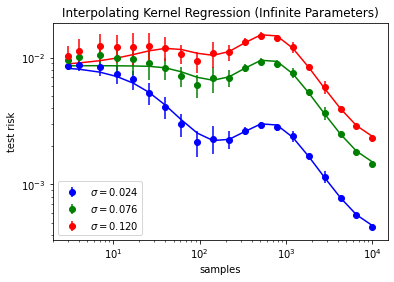

Time Elapsed: 0h 0m 41s


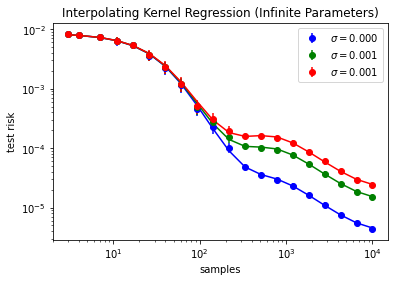

In [8]:
timestamp = time_now()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Experiment Parameters
num_repeats_ker = 15 #150
num_repeats_nn = 5 #5
num_iter_nn = 500

## NN Hyperparameters
lr = 0.008
width = 2000
layers = 1
ensemble_size_list = [20]

## Dimension, sample sizes, max eigenvalue mode
dim = 30
pvals = npo.logspace(0.5, 4, num = 20).astype('int')
p_test = 1500
kmax = 200

## Target function mode and label noise
fn_mode = 1
noise_num = 2
shift = npo.array([-0.8, 0, 1])
R_tilde = 0.5

key = random.PRNGKey(0)
all_keys = random.split(key, max(num_repeats_nn, num_repeats_ker))

if save_data:
  parent = save_dir + 'NNExp_width_%d-layer_%d-fn_mode_%d/'%(width,layers,fn_mode)
  ensure_dir(parent)

# create NN and kernel function
init_fn, apply_fn, kernel_fn = fully_connected(layers, width)
apply_fn = jit(apply_fn)
kernel_fn = jit(kernel_fn, static_argnums=(2,))

# Generate Theory curves and Noise
Sol, Errs_tot, noise, alpha_s, spectrum, degens = NTK_theory_and_Noise(pvals, layers, dim, kmax, noise_num, shift, 
                                                                      R_tilde, fn_mode = fn_mode, zero_mode=False)

params = {'dim': dim, 'kmax': kmax, 'layer': layers, 'width': width,
          'test_samp': p_test, 'num_repeat_ker': num_repeats_ker, 
          'num_repeat_nn': num_repeats_nn, 'num_iter_nn': num_iter_nn, 
          'noise': noise, 'noise_num': noise_num, 'shift': shift, 
          'ensemble_size_list': ensemble_size_list, 'fn_mode': fn_mode, 
          'alpha_s': alpha_s, 'degens': degens}

if save_data:
  filename_theory = parent + timestamp + 'error_theory.npz'
  np.savez(filename_theory, pvals, Sol, Errs_tot, params)

### Start the kernel experiment

err_regression = npo.zeros((noise_num, len(shift), len(pvals)))
std_regression = npo.zeros((noise_num, len(shift), len(pvals)))

print('Kernel Regression Start @ ' + time_now())
for i in range(noise_num):
  t_start = datetime.now()
  for j in range(len(shift)):
    data = kernel_expt(kernel_fn, pvals, p_test, noise[i, j], dim, spectrum, num_repeats_ker, all_keys, R_tilde, fn_mode = fn_mode)
    err_regression[i, j] = data[0]
    std_regression[i, j] = data[1]
  
  t_end = datetime.now()
  print('Time Elapsed: ' + time_diff(t_start,t_end))

  plot_shift_data(pvals, err_regression, std_regression, Errs_tot, i, noise, 'kernel')
if save_data:
  filename_exp = directory + timestamp + 'final_error_exp_NN.npz'
  np.savez(filename_exp, err_NN, std_NN, tr_err_NN, std_tr_err_NN)

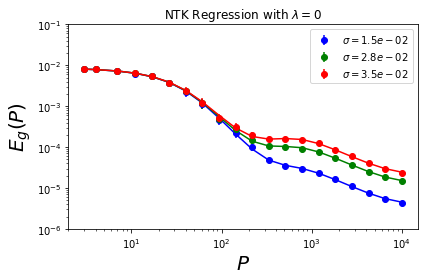

In [9]:
i = 1
shift = len(noise[i])
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for j in range(shift):
    plt.errorbar(pvals, err_regression[i,j], std_regression[i,j], fmt='o', label = r'$\sigma = %.1e$' % np.sqrt(noise[i,j]), color=colors[j])
    plt.plot(pvals, Errs_tot[j,:,i], color=colors[j])

plt.title('NTK Regression with $\lambda = 0$')

plt.ylim([1e-6, 1e-1])
plt.xlabel('$P$', fontsize = 20)
plt.ylabel('$E_g(P)$', fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('NTK_regression_R_tilde_0_5.pdf')
plt.show()